# Sentiment Analysis of Reviews using Natural Language Processing (NLP)

Three sentiment analysis approaches: Machine Learning, Deep learning, and Lexicon-based learning will be considered for analysis. In machine learning we will used Naive Bayes, in Lexicon-based learning we have VADER(Valence Aware Dictionary and sEntiment Reasoner), and in Deep learning we use DistilBERT(Distilled Bidirectional Encoder Representations from Transformers) for sentiment analysis

### Import libraries

In [1]:
import pandas as pd
import numpy as np
import glob
import keras
import tensorflow as tf
import nltk
from wordcloud import WordCloud
from nltk.corpus import stopwords
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.model_selection import train_test_split
from keras.preprocessing.text import text_to_word_sequence
from nltk.tokenize import word_tokenize
from nltk.sentiment.vader import SentimentIntensityAnalyzer
from sklearn import preprocessing, metrics
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix, precision_recall_curve, roc_curve, auc
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import label_binarize

In [2]:
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/tresakuruvilla/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

### Load Dataset and Pre-process

Here there are 9 csvs with various mobile device ratings. Analysis will be by merging all the mobile devices and identifying the classification of sentiments i.e. positive, negative, and neutral. In case of a good distribution, this analysis can have be compared using 3 sentiments else 2 sentiments(positive and negative). A rating of 3 would be considered as neutral, <3 as negative and >3 as positive

Performing the same analysis on a single mobile device, it is concluded that having a neutral rating would not add a significant importance to the analysis as the number of records were significantly low. Hence, the rating 3 and below will be classified as negative and rating above 3 will be classified as positive.

In [3]:
 # list all csv files only
csv_files = glob.glob('data/amazon/*.{}'.format('csv'))
csv_files

['data/amazon/micromax.csv',
 'data/amazon/oppo.csv',
 'data/amazon/redmi.csv',
 'data/amazon/iphone.csv',
 'data/amazon/moto.csv',
 'data/amazon/nokia.csv',
 'data/amazon/panasonic.csv',
 'data/amazon/vivo.csv',
 'data/amazon/lenova.csv']

In [4]:
df_csv_append = pd.DataFrame()
 
# append the CSV files
for file in csv_files:
    df = pd.read_csv(file, encoding='latin-1', header=None, usecols=[4,5,6])
    df_csv_append = pd.concat([df_csv_append,df], ignore_index=True)
 
df_csv_append.shape

(161192, 3)

In [5]:
df_csv_append.columns = ['rating', 'reviewTitle', 'reviews']
df_csv_append.head(5)

,rating,reviewTitle,reviews
0,4,Wonderful,Nice product\n \n \n\n READ MORE\n \n
1,5,Mind-blowing purchase,Super......\n \n \n\n READ MORE\n \n
2,4,Good quality product,Good .Non removable battery Good battery back ...
3,4,Superb...,"Camera quality excellent,Display crystal clear..."
4,4,Pretty good,GOOD.. i bought this for my motherat the cost ...


<Axes: >

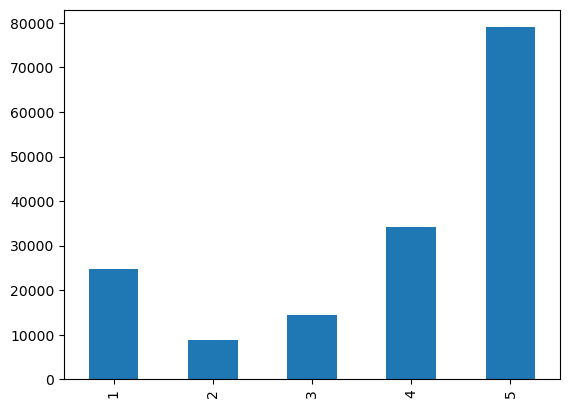

In [6]:
df_csv_append.rating.value_counts().sort_index().plot(kind='bar')

In [7]:
df = pd.read_csv("data/amazon/lenova.csv", encoding='latin-1', header=None, usecols=[4,5,6])
df.head(5)

,4,5,6
0,5,LENOVO VIBE K5 PLUS IS A EXCELLENT PHONE.,LENOVO VIBE K5 PLUS IS AN EXCELLENT PHONE.\n ...
1,4,Wonderful,Good phone\n \n For the first time using thi...
2,5,LENOVO VIBE K5 PLUS 3GB,"DELIVERY, TRACKING UPDATE, EXCELLENT AS COMMIT..."
3,4,Worth a Buy !!!,Dolby Sound is Amazing.....\n \n \n\n READ M...
4,1,Utterly Disappointed,Major heating problem and battery drains real ...


In [8]:
df.columns = ['rating', 'reviewTitle', 'reviews']
df.head(5)

,rating,reviewTitle,reviews
0,5,LENOVO VIBE K5 PLUS IS A EXCELLENT PHONE.,LENOVO VIBE K5 PLUS IS AN EXCELLENT PHONE.\n ...
1,4,Wonderful,Good phone\n \n For the first time using thi...
2,5,LENOVO VIBE K5 PLUS 3GB,"DELIVERY, TRACKING UPDATE, EXCELLENT AS COMMIT..."
3,4,Worth a Buy !!!,Dolby Sound is Amazing.....\n \n \n\n READ M...
4,1,Utterly Disappointed,Major heating problem and battery drains real ...


In [9]:
df.shape

(26600, 3)

<Axes: xlabel='rating', ylabel='count'>

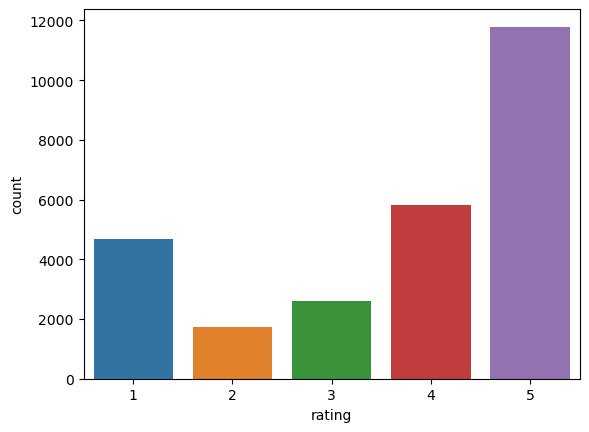

In [10]:
sns.countplot(data=df, x="rating")

In [11]:
df['sentiment'] = df['rating'].apply(lambda rate: 1 if (rate>3) else 0)
df = df[['reviews','rating','sentiment']]
df1 = df.head(10)

In [12]:
df['sentiment'].value_counts()

1    17599
0     9001
Name: sentiment, dtype: int64

#### Check presence of imbalanced data of positive and negative sentiments. 

In [13]:
9001/17599

0.5114495141769418

In [14]:
dfFinal = df.copy() #using lenovo data for further analysis
dfFinal.head(10)

,reviews,rating,sentiment
0,LENOVO VIBE K5 PLUS IS AN EXCELLENT PHONE.\n ...,5,1
1,Good phone\n \n For the first time using thi...,4,1
2,"DELIVERY, TRACKING UPDATE, EXCELLENT AS COMMIT...",5,1
3,Dolby Sound is Amazing.....\n \n \n\n READ M...,4,1
4,Major heating problem and battery drains real ...,1,0
5,I don't understand why manufacturer boast only...,1,0
6,My mobile good but battery over heating\n \n \...,2,0
7,This is a super phone I have used for one mont...,5,1
8,Thanks for VoLTE update via OTA and camera qua...,4,1
9,Must Read this full review...\n \n\n I'm swi...,1,0


### Wordcloud

Tokenizing the text and removing stopwords to represent the sentiments using wordcloud.

In [15]:
def tokenizeKeras(d):
    return text_to_word_sequence(d)

In [16]:
dfFinal['token_text'] = dfFinal.reviews.apply(tokenizeKeras)

In [17]:
def clean_stopwords(d):
    stop_words = set(stopwords.words('english'))
    # Additional words to be added to the default set of stop words
    additional_stop_words = {'READ MORE', '\n', 'phone', 'mobile', 'read','even','one'}

    # Extend the default set of stop words with the additional words
    custom_stop_words = stop_words.union(additional_stop_words)

    cleaned_text = []
    for w in d:
        if w not in custom_stop_words:
            cleaned_text.append(w)
    return cleaned_text
            

In [18]:
dfFinal['clean_text'] = dfFinal.token_text.apply(clean_stopwords)
dfFinal['final_text'] = dfFinal['clean_text'].apply(lambda review: " ".join(review))
dfFinal.drop(['token_text', 'clean_text'], axis=1)

,reviews,rating,sentiment,final_text
0,LENOVO VIBE K5 PLUS IS AN EXCELLENT PHONE.\n ...,5,1,lenovo vibe k5 plus excellent fast smooth work...
1,Good phone\n \n For the first time using thi...,4,1,good first time using mild heating issue 10 mi...
2,"DELIVERY, TRACKING UPDATE, EXCELLENT AS COMMIT...",5,1,delivery tracking update excellent committed
3,Dolby Sound is Amazing.....\n \n \n\n READ M...,4,1,dolby sound amazing
4,Major heating problem and battery drains real ...,1,0,major heating problem battery drains real quick
...,...,...,...,...
26595,Very nice phone with low cost on flipkart\n \n...,4,1,nice low cost flipkart
26596,Very good Product\n \n \n\n READ MORE\n \n,5,1,good product
26597,It's a very good phone that to smart in batter...,5,1,good smart battery camera also mode update nought
26598,Nice one\n \n \n\n READ MORE\n \n,4,1,nice


In [19]:
df_pos = dfFinal[dfFinal['sentiment'] == 1]
df_neg = dfFinal[dfFinal['sentiment'] == 0]

In [20]:
#dfWordCloud = dfFinal.sample(n=50)
pos_reviews_text = " ".join(df_pos['final_text'].dropna())
neg_reviews_text = " ".join(df_neg['final_text'].dropna())

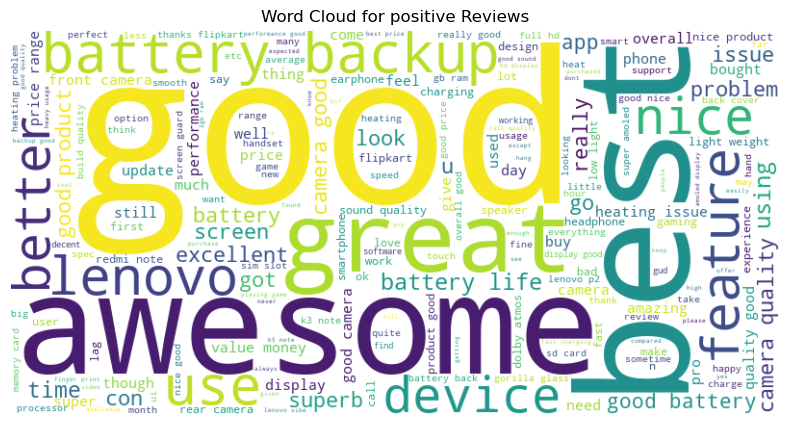

In [21]:
# Create a WordCloud object for positive reviews
wordcloud = WordCloud(width=800, height=400, background_color='white', max_words=200).generate(pos_reviews_text)

# Display the generated word cloud using matplotlib
plt.figure(figsize=(10, 5))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.title("Word Cloud for positive Reviews")
plt.show()

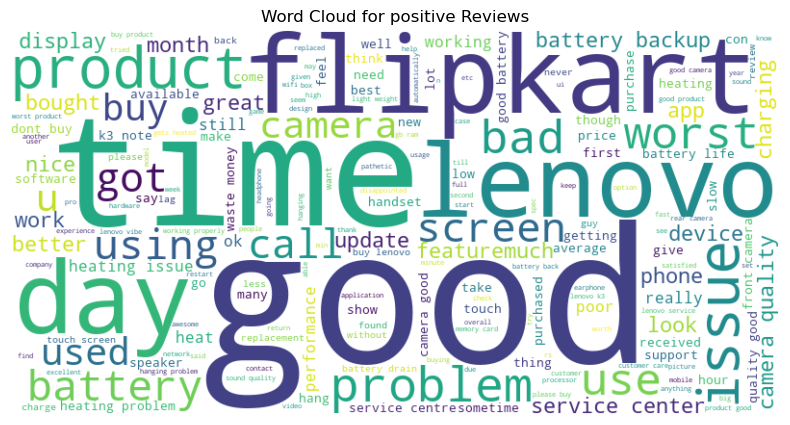

In [22]:
# Create a WordCloud object for negative reviews
wordcloud = WordCloud(width=800, height=400, background_color='white', max_words=200).generate(neg_reviews_text)

# Display the generated word cloud using matplotlib
plt.figure(figsize=(10, 5))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.title("Word Cloud for positive Reviews")
plt.show()

### Feature extraction using Bag-Of-Words

In [23]:
vectorizer = CountVectorizer()
X = vectorizer.fit_transform(dfFinal['reviews'])
X

<26600x15709 sparse matrix of type '<class 'numpy.int64'>'
	with 809368 stored elements in Compressed Sparse Row format>

In [24]:
# Split the data into Train, Validation, and Test datasets
X_train, X_temp, y_train, y_temp = train_test_split(X, dfFinal['sentiment'], test_size=0.3, 
                                                    random_state=42)
X_test, X_val, y_test, y_val = train_test_split(X_temp, y_temp, test_size=0.5, 
                                                random_state=42)

In [25]:
X_train

<18620x15709 sparse matrix of type '<class 'numpy.int64'>'
	with 569940 stored elements in Compressed Sparse Row format>

## Naive Bayes

In [26]:
# Train the Naive Bayes classifier 
naiveB_classifier = MultinomialNB()
naiveB_classifier.fit(X_train, y_train)

MultinomialNB()

In [27]:
# Predict the sentiment of the validation data
y_pred_val = naiveB_classifier.predict(X_val)

# Calculate the accuracy score on the validation data
accuracy_val_nb = accuracy_score(y_val, y_pred_val)
print("Validation Accuracy: ",accuracy_val_nb)

Validation Accuracy:  0.8511278195488722


In [28]:
# Predict the sentiment of the test data
y_pred_test = naiveB_classifier.predict(X_test)

# Calculate the accuracy score on test data
accuracy_test_nb = accuracy_score(y_test, y_pred_test)
print("Test Accuracy: ",accuracy_test_nb)

Test Accuracy:  0.8506265664160401


In [29]:
report = classification_report(y_test, y_pred_test)
print(report)

              precision    recall  f1-score   support

           0       0.84      0.68      0.75      1311
           1       0.86      0.94      0.89      2679

    accuracy                           0.85      3990
   macro avg       0.85      0.81      0.82      3990
weighted avg       0.85      0.85      0.85      3990



In [30]:
report = classification_report(y_test, y_pred_test, output_dict=True)
print(report)

{'0': {'precision': 0.8363123236124177, 'recall': 0.6781083142639207, 'f1-score': 0.7489469250210616, 'support': 1311}, '1': {'precision': 0.8558250768705159, 'recall': 0.93505039193729, 'f1-score': 0.89368533713878, 'support': 2679}, 'accuracy': 0.8506265664160401, 'macro avg': {'precision': 0.8460687002414669, 'recall': 0.8065793531006054, 'f1-score': 0.8213161310799209, 'support': 3990}, 'weighted avg': {'precision': 0.8494137436571408, 'recall': 0.8506265664160401, 'f1-score': 0.8461284303001011, 'support': 3990}}


In [31]:
df_report = pd.DataFrame(report).transpose()

# Display the DataFrame

print(df_report)  # Print the DataFrame to verify it
# Export DataFrame to CSV
csv_filename = 'classification_report-NB.csv'
df_report.to_csv(csv_filename, index=True)

              precision    recall  f1-score      support
0              0.836312  0.678108  0.748947  1311.000000
1              0.855825  0.935050  0.893685  2679.000000
accuracy       0.850627  0.850627  0.850627     0.850627
macro avg      0.846069  0.806579  0.821316  3990.000000
weighted avg   0.849414  0.850627  0.846128  3990.000000


In [32]:
# Generate confusion matrix for test data
confusion_test = confusion_matrix(y_test, y_pred_test)
print("Confusion Matrix (Test Data): \n", confusion_test)

Confusion Matrix (Test Data): 
 [[ 889  422]
 [ 174 2505]]


In [33]:
naiveB_classifier.classes_

array([0, 1])

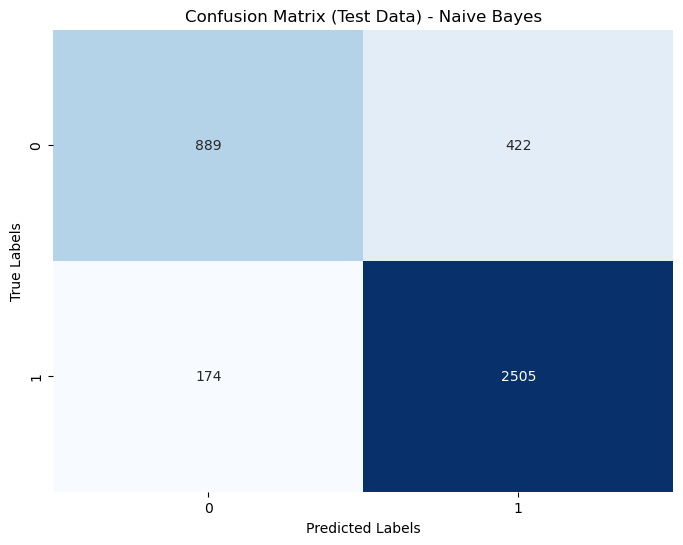

In [34]:
#Visualise the confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(confusion_test, annot=True, fmt="d", cmap="Blues", cbar=False,
            xticklabels=naiveB_classifier.classes_, yticklabels=naiveB_classifier.classes_)
plt.xlabel("Predicted Labels")
plt.ylabel("True Labels")
plt.title("Confusion Matrix (Test Data) - Naive Bayes")
plt.show()

In [35]:
# Predict the sentiment probabilities of the test data
y_pred_prob = naiveB_classifier.predict_proba(X_test)
y_pred_prob_positive = y_pred_prob[:, 1]  # Probability of positive class
y_pred_prob_positive

array([0.6980796 , 0.01593688, 0.79486505, ..., 0.55575324, 0.81241767,
       0.96685179])

In [36]:
y_pred_prob_positive.shape

(3990,)

In [37]:
y_test.shape

(3990,)

In [38]:
# Binarize the test labels
y_test_bin = label_binarize(y_test, classes=[0, 1])
n_classes = y_test_bin.shape[1]

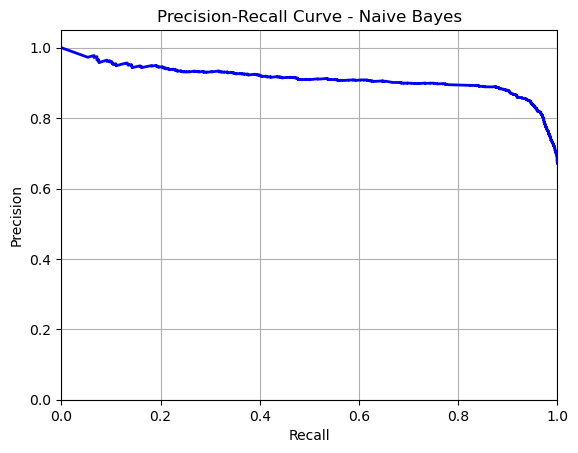

In [39]:
# Calculate precision and recall
precision, recall, thresholds_pr = precision_recall_curve(y_test.ravel(), y_pred_prob_positive.ravel())

# Calculate F1-score for different thresholds
f1_scores = 2 * (precision * recall) / (precision + recall)

# Identify optimal threshold based on F1-score
optimal_threshold = thresholds_pr[f1_scores.argmax()]

# Plot Precision-Recall Curve
plt.figure()
plt.plot(recall, precision, color='b', lw=2)
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve - Naive Bayes')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.grid(True)
plt.savefig("Precision-Recall Curve - Naive Bayes.png")
plt.show()

In [40]:
print('Naive Bayes threshold: ', optimal_threshold)

Naive Bayes threshold:  0.4074840005464468


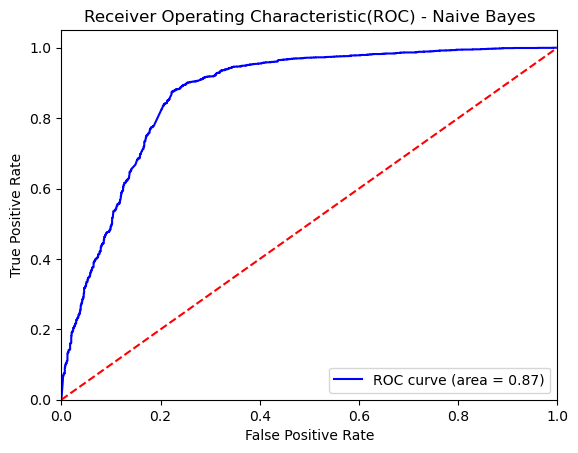

In [41]:
fpr, tpr, thresholds_roc = roc_curve(y_test, y_pred_prob_positive)

roc_auc = auc(fpr,tpr)

plt.title('Receiver Operating Characteristic(ROC) - Naive Bayes')
plt.plot(fpr, tpr, 'b', label = 'ROC curve (area = %0.2f)' % roc_auc)
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

### Prediction of test data - Naive Bayes

In [42]:
dfPredicted = pd.DataFrame(columns=['Text', 'Truth', 'Predicted'])
labels = ['Negative','Positive']

In [43]:
new_text = "This is a super phone I have used for one month no problem was happened it is a super and Wonder ful phone.......Happy"
new_text_bow = vectorizer.transform([new_text])
new_text_pred = naiveB_classifier.predict(new_text_bow)

predData = {'Text': new_text, 'Truth': 'Positive', 'Predicted': labels[new_text_pred[0]]}
new_df = pd.DataFrame([predData])
dfPredicted = dfPredicted.append(predData, ignore_index=True)

/var/folders/jb/dpgstc9s58q3s_p769xtx63m0000gn/T/ipykernel_29078/544026599.py:7: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  dfPredicted = dfPredicted.append(predData, ignore_index=True)


In [44]:
new_text = "I don't understand why manufacturer boast only 2750mah battery.Absolutely rubbish mobile every mobile having quick charge function but it's having quick discharge function."
new_text_bow = vectorizer.transform([new_text])
new_text_pred = naiveB_classifier.predict(new_text_bow)
predData = {'Text': new_text, 'Truth': 'Negative', 'Predicted': labels[new_text_pred[0]]}
new_df = pd.DataFrame([predData])
dfPredicted = dfPredicted.append(predData, ignore_index=True)

/var/folders/jb/dpgstc9s58q3s_p769xtx63m0000gn/T/ipykernel_29078/3430972338.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  dfPredicted = dfPredicted.append(predData, ignore_index=True)


In [45]:
new_text = "Must Read this full review... I'm switched from infocus M2 3G to this Lenovo vibe k5 plus... @6749 on BBD sale. After one day use , I write my review From the package I got mobile, battery, charging adapter, data cable, plastic back case, screen protection film but no ear phones. *Design is looking good and handy. *Camera back 13 mp but not better than my infocus M2(8mp) , both are almost equal.  *camera front is very clear to take selfies.  *touch is very good to use and display amazing. *Dolby speakers , sound is better than normal. *phone is heating very rarely. *comes to multitasking, 3GB RAM works fine , not hanged till now. *Battery backup is not good as excepted , but OK for normal use. I chooses this mobile for this price tag of Rs.6749 at BBD sale , I would recommend at price tag of 8.5k search for other Mobiles with high battery back up. If u don't want much battery back up, then go for this mobile. Wait wait wait ! The above given review is only after one day use , now I'm editing this review after one month heavy usage of lenevo vibe k5 plus... This is worst phone I've ever used , very much irritating to use , heating , hanging and everything was happening... Not able to use continuously for 1hour , after continuously using one hour , it heats and hangs on every action, even calls are not able to attend on that time , only ringtone is ringing but screen is in black... Conclusion : this phone specs only on label 3GB ram , 1.5GHz Octacore,,, this is processing like 512MB ram . I'm saled this bricky mobile to low price , and bought Infocus bingo 50+ and this review also writing on my new Infocus mobile... Guys I'm shared my experience with Lenevo vibe k5 plus , now u decide u wanna buy it not...Thank you !"
new_text_bow = vectorizer.transform([new_text])
new_text_pred = naiveB_classifier.predict(new_text_bow)
predData = {'Text': new_text, 'Truth': 'Negative', 'Predicted': labels[new_text_pred[0]]}
new_df = pd.DataFrame([predData])
dfPredicted = dfPredicted.append(predData, ignore_index=True)

/var/folders/jb/dpgstc9s58q3s_p769xtx63m0000gn/T/ipykernel_29078/1508177665.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  dfPredicted = dfPredicted.append(predData, ignore_index=True)


In [46]:
new_text = "very good mobile, built quality and feel in the hand is very good... very fast...3 GB RAM 16 GB internal memory...,,, heats up a bit though but thats not an issue once u upgrade the software,, camera quality is good for proce range...Best buy in this price range... Excellent service from flipkart,,,, package was delivered safely in excellent condition and much before the expected date.. trust only flipcart....great experience"
new_text_bow = vectorizer.transform([new_text])
new_text_pred = naiveB_classifier.predict(new_text_bow)
predData = {'Text': new_text, 'Truth': 'Positive', 'Predicted': labels[new_text_pred[0]]}
new_df = pd.DataFrame([predData])
dfPredicted = dfPredicted.append(predData, ignore_index=True)

/var/folders/jb/dpgstc9s58q3s_p769xtx63m0000gn/T/ipykernel_29078/1312526499.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  dfPredicted = dfPredicted.append(predData, ignore_index=True)


In [47]:
new_text = "my laptop's battery will last 8 hours when it is fully charged"
new_text_bow = vectorizer.transform([new_text])
new_text_pred = naiveB_classifier.predict(new_text_bow)
predData = {'Text': new_text, 'Truth': 'Positive', 'Predicted': labels[new_text_pred[0]]}
print("Predicted: ", labels[new_text_pred[0]])

Predicted:  Negative


In [48]:
dfPredicted.to_csv('prediction_NB.csv', index=True)

In [49]:
dfPredicted

,Text,Truth,Predicted
0,This is a super phone I have used for one mont...,Positive,Positive
1,I don't understand why manufacturer boast only...,Negative,Negative
2,Must Read this full review... I'm switched fro...,Negative,Negative
3,"very good mobile, built quality and feel in th...",Positive,Positive


## VADER (Valence Aware Dictionary sEntiment Reasoner)

In [50]:
nltk.download('vader_lexicon')

[nltk_data] Downloading package vader_lexicon to
[nltk_data]     /Users/tresakuruvilla/nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


True

In [51]:
dfVader = df.copy()

In [52]:
# Split the data into Train, Validation, and Test datasets
X_train, X_temp, y_train, y_temp = train_test_split(dfVader['reviews'], dfVader['sentiment'], test_size=0.3, 
                                                    random_state=42)
X_test, X_val, y_test, y_val = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42)

In [53]:
vader = SentimentIntensityAnalyzer()
vader.polarity_scores(X_train[8])

{'neg': 0.0, 'neu': 0.676, 'pos': 0.324, 'compound': 0.8888}

In [54]:
def predict_sentiment_score(data):
    y_pred_vader_score = data.apply(lambda review: vader.polarity_scores(review))
    y_pred_vader = y_pred_vader_score.apply(lambda score: 1 if score['compound'] > 0 else 0)
    return y_pred_vader

In [55]:
y_pred_train = predict_sentiment_score(X_train)
y_pred_val = predict_sentiment_score(X_val)
y_pred_test = predict_sentiment_score(X_test)

In [56]:
def get_sentiment_scores(text):
    return vader.polarity_scores(text)['compound']

# Calculate sentiment scores for testing data
test_sentiment_scores = X_test.apply(get_sentiment_scores)

In [57]:
# Get the class labels
classes = np.unique(y_train)
classes

array([0, 1])

In [58]:
# Calculate the accuracy score on train, validation, and test data
accuracy_train_vader = accuracy_score(y_train, y_pred_train)
accuracy_val_vader = accuracy_score(y_val, y_pred_val)
accuracy_test_vader = accuracy_score(y_test, y_pred_test)

In [59]:
print("Train Accuracy: ",accuracy_train_vader)
print("Validation Accuracy: ",accuracy_val_vader)
print("Test Accuracy: ",accuracy_test_vader)

Train Accuracy:  0.8045649838882921
Validation Accuracy:  0.7957393483709273
Test Accuracy:  0.8085213032581454


In [60]:
print(classification_report(y_test, y_pred_test))

              precision    recall  f1-score   support

           0       0.74      0.64      0.69      1311
           1       0.83      0.89      0.86      2679

    accuracy                           0.81      3990
   macro avg       0.79      0.76      0.77      3990
weighted avg       0.80      0.81      0.80      3990



In [61]:
# Calculate confusion matrix
train_cm = confusion_matrix(y_train, y_pred_train)
validation_cm = confusion_matrix(y_val, y_pred_val)
test_cm = confusion_matrix(y_test, y_pred_test)
test_cm

array([[ 834,  477],
       [ 287, 2392]])

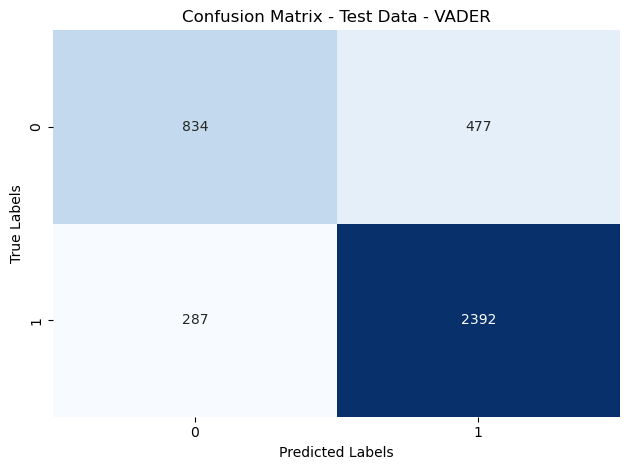

In [62]:
sns.heatmap(test_cm, annot=True, fmt="d", cmap="Blues", cbar=False,
            xticklabels=np.unique(y_test), yticklabels=np.unique(y_test))
plt.xlabel("Predicted Labels")
plt.ylabel("True Labels")
plt.title("Confusion Matrix - Test Data - VADER")

plt.tight_layout()
plt.show()

In [63]:
precision, recall,thresholds_pr = precision_recall_curve(y_test, test_sentiment_scores)


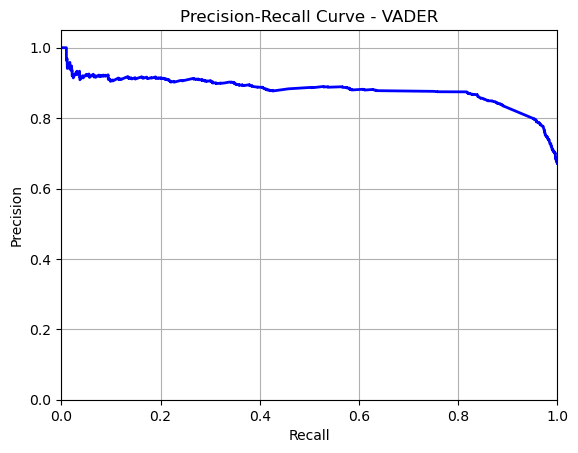

In [64]:
# Plot Precision-Recall Curve
plt.figure()
plt.plot(recall, precision, color='b', lw=2)
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve - VADER')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.grid(True)
plt.show()

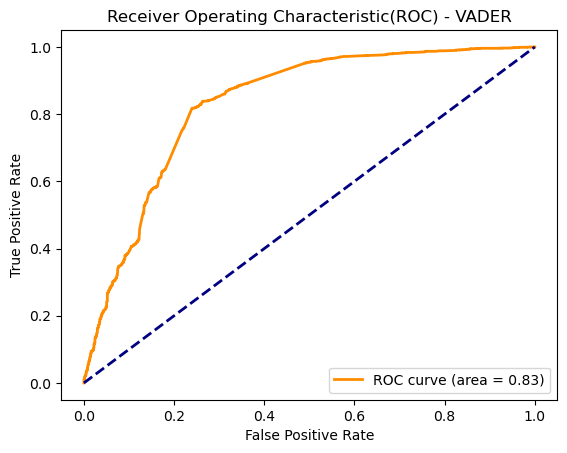

In [65]:
# Calculate ROC curve
fpr, tpr, thresholds_roc = roc_curve(y_test, test_sentiment_scores)
roc_auc = auc(fpr, tpr)

# Plot ROC Curve
plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic(ROC) - VADER')
plt.legend(loc='lower right')
plt.show()

### Prediction of test data - VADER

In [66]:
dfPredicted = pd.DataFrame(columns=['Text', 'Truth', 'Predicted'])
labels = ['Negative','Positive']

In [67]:
new_text = "This is a super phone I have used for one month no problem was happened it is a super and Wonder ful phone.......Happy"
new_text_pred = get_sentiment_scores(new_text)
print(new_text_pred)
new_pred = (1 if new_text_pred >= 0 else 0)
predData = {'Text': new_text, 'Truth': 'Positive', 'Predicted': labels[new_pred]}
new_df = pd.DataFrame([predData])
dfPredicted = dfPredicted.append(predData, ignore_index=True)

0.5994


/var/folders/jb/dpgstc9s58q3s_p769xtx63m0000gn/T/ipykernel_29078/979575567.py:7: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  dfPredicted = dfPredicted.append(predData, ignore_index=True)


In [68]:
new_text = "I don't understand why manufacturer boast only 2750mah battery.Absolutely rubbish mobile every mobile having quick charge function but it's having quick discharge function."
new_text_pred = get_sentiment_scores(new_text)
print(new_text_pred)
new_pred = (1 if new_text_pred >= 0 else 0)
predData = {'Text': new_text, 'Truth': 'Negative', 'Predicted': labels[new_pred]}
new_df = pd.DataFrame([predData])
dfPredicted = dfPredicted.append(predData, ignore_index=True)

0.0


/var/folders/jb/dpgstc9s58q3s_p769xtx63m0000gn/T/ipykernel_29078/3990462089.py:7: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  dfPredicted = dfPredicted.append(predData, ignore_index=True)


In [69]:
new_text = "Must Read this full review... I'm switched from infocus M2 3G to this Lenovo vibe k5 plus... @6749 on BBD sale. After one day use , I write my review From the package I got mobile, battery, charging adapter, data cable, plastic back case, screen protection film but no ear phones. *Design is looking good and handy. *Camera back 13 mp but not better than my infocus M2(8mp) , both are almost equal.  *camera front is very clear to take selfies.  *touch is very good to use and display amazing. *Dolby speakers , sound is better than normal. *phone is heating very rarely. *comes to multitasking, 3GB RAM works fine , not hanged till now. *Battery backup is not good as excepted , but OK for normal use. I chooses this mobile for this price tag of Rs.6749 at BBD sale , I would recommend at price tag of 8.5k search for other Mobiles with high battery back up. If u don't want much battery back up, then go for this mobile. Wait wait wait ! The above given review is only after one day use , now I'm editing this review after one month heavy usage of lenevo vibe k5 plus... This is worst phone I've ever used , very much irritating to use , heating , hanging and everything was happening... Not able to use continuously for 1hour , after continuously using one hour , it heats and hangs on every action, even calls are not able to attend on that time , only ringtone is ringing but screen is in black... Conclusion : this phone specs only on label 3GB ram , 1.5GHz Octacore,,, this is processing like 512MB ram . I'm saled this bricky mobile to low price , and bought Infocus bingo 50+ and this review also writing on my new Infocus mobile... Guys I'm shared my experience with Lenevo vibe k5 plus , now u decide u wanna buy it not...Thank you !"
new_text_pred = get_sentiment_scores(new_text)
print(new_text_pred)
new_pred = (1 if new_text_pred >= 0 else 0)
predData = {'Text': new_text, 'Truth': 'Negative', 'Predicted': labels[new_pred]}
new_df = pd.DataFrame([predData])
dfPredicted = dfPredicted.append(predData, ignore_index=True)

0.9413


/var/folders/jb/dpgstc9s58q3s_p769xtx63m0000gn/T/ipykernel_29078/3639389687.py:7: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  dfPredicted = dfPredicted.append(predData, ignore_index=True)


In [70]:
new_text = "very good mobile, built quality and feel in the hand is very good... very fast...3 GB RAM 16 GB internal memory...,,, heats up a bit though but thats not an issue once u upgrade the software,, camera quality is good for proce range...Best buy in this price range... Excellent service from flipkart,,,, package was delivered safely in excellent condition and much before the expected date.. trust only flipcart....great experience"
new_text_pred = get_sentiment_scores(new_text)
print(new_text_pred)
new_pred = (1 if new_text_pred >= 0 else 0)
predData = {'Text': new_text, 'Truth': 'Positive', 'Predicted': labels[new_pred]}
new_df = pd.DataFrame([predData])
dfPredicted = dfPredicted.append(predData, ignore_index=True)

0.9823


/var/folders/jb/dpgstc9s58q3s_p769xtx63m0000gn/T/ipykernel_29078/3981626486.py:7: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  dfPredicted = dfPredicted.append(predData, ignore_index=True)


In [71]:
new_text = "Poor caemra and touch and other fetures I think not deserved 3 gb ram mobile"
new_text_pred = get_sentiment_scores(new_text)
print(new_text_pred)
new_pred = (1 if new_text_pred >= 0 else 0)
predData = {'Text': new_text, 'Truth': 'Negative', 'Predicted': labels[new_pred]}
new_df = pd.DataFrame([predData])
dfPredicted = dfPredicted.append(predData, ignore_index=True)

-0.4767


/var/folders/jb/dpgstc9s58q3s_p769xtx63m0000gn/T/ipykernel_29078/2618275022.py:7: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  dfPredicted = dfPredicted.append(predData, ignore_index=True)


In [72]:
new_text = "my laptop's battery will last 8 hours when it is fully charged"
new_text_pred = get_sentiment_scores(new_text)
#new_pred = (1 if new_text_pred >= 0 else 0)

print('Predicted: ', new_text_pred)

Predicted:  -0.2716


In [73]:
dfPredicted

,Text,Truth,Predicted
0,This is a super phone I have used for one mont...,Positive,Positive
1,I don't understand why manufacturer boast only...,Negative,Positive
2,Must Read this full review... I'm switched fro...,Negative,Positive
3,"very good mobile, built quality and feel in th...",Positive,Positive
4,Poor caemra and touch and other fetures I thin...,Negative,Negative


In [74]:
dfPredicted.to_csv('prediction_V1.csv', index=True)

### BERT (Bidirectional Encoder Representations from Transformers)

In [75]:
from transformers import DistilBertTokenizerFast, TFDistilBertForSequenceClassification
from torch.utils.data import DataLoader
import pickle
import torch

In [76]:
reviews = df['reviews'].values.tolist()
labels = df['sentiment'].tolist()
print(reviews[:2])
print(labels[:2])

['LENOVO VIBE K5 PLUS IS AN EXCELLENT PHONE.\n  \n  FAST & SMOOTH WORKING/ PROCESSING.\n  \n  BATTERY POWER SHOULD BE INCREASE. BUT AT THIS PRICE THIS PHONE IS SUPER.\n  \n  VERY FAST DELIVERY BY FLIP-KART.\n  \n  I am using this phone from last 15 days. Excellent phone.\n \n \n\n   READ MORE\n  \n', 'Good phone\n  \n  For the first time using this phone there was a mild heating issue for 10 min which usual in all brands and now there is no heating issue.\n  \n  Good rear camera\n  \n  Overall good performance....\n \n \n\n   READ MORE\n  \n']
[1, 1]


In [77]:
X_train, X_temp, y_train, y_temp = train_test_split(reviews, labels, test_size=0.3, random_state=42)
X_test, X_val, y_test, y_val = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42)

In [78]:
tokenizer = DistilBertTokenizerFast.from_pretrained('distilbert-base-uncased')
train_encodings = tokenizer(X_train,
                            truncation=True,
                            padding=True)
val_encodings = tokenizer(X_val,
                            truncation=True,
                            padding=True)
test_encodings = tokenizer(X_test,
                            truncation=True,
                            padding=True)

In [79]:
train_dataset = tf.data.Dataset.from_tensor_slices((
    dict(train_encodings),
    y_train
))

val_dataset = tf.data.Dataset.from_tensor_slices((
    dict(val_encodings),
    y_val
))

test_dataset = tf.data.Dataset.from_tensor_slices((
    dict(test_encodings),
    y_test
))

In [80]:
model = TFDistilBertForSequenceClassification.from_pretrained('distilbert-base-uncased',num_labels=2)

Some layers from the model checkpoint at distilbert-base-uncased were not used when initializing TFDistilBertForSequenceClassification: ['activation_13', 'vocab_layer_norm', 'vocab_transform', 'vocab_projector']
- This IS expected if you are initializing TFDistilBertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFDistilBertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some layers of TFDistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier', 'pre_classifier', 'dropout_19']
You should probably TRAIN this model on a down-stream task to be able to use i

In [81]:
model.summary()

Model: "tf_distil_bert_for_sequence_classification"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 distilbert (TFDistilBertMai  multiple                 66362880  
 nLayer)                                                         
                                                                 
 pre_classifier (Dense)      multiple                  590592    
                                                                 
 classifier (Dense)          multiple                  1538      
                                                                 
 dropout_19 (Dropout)        multiple                  0         
                                                                 
Total params: 66,955,010
Trainable params: 66,955,010
Non-trainable params: 0
_________________________________________________________________


#### Run Sentiment_analysis_using_BERT.py before running the below steps

In [82]:
model = TFDistilBertForSequenceClassification.from_pretrained("data/fine_tuned_bert")

optimizer = tf.keras.optimizers.Adam(learning_rate=5e-5, epsilon=1e-08)
loss = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True)
model.compile(optimizer=optimizer, loss=loss, metrics=['accuracy'])
# model.fit(train_dataset.shuffle(100).batch(16),
#           epochs=2,
#           batch_size=16,
#           validation_data=val_dataset.shuffle(100).batch(16))


Some layers from the model checkpoint at data/fine_tuned_bert were not used when initializing TFDistilBertForSequenceClassification: ['dropout_19']
- This IS expected if you are initializing TFDistilBertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFDistilBertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some layers of TFDistilBertForSequenceClassification were not initialized from the model checkpoint at data/fine_tuned_bert and are newly initialized: ['dropout_39']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [82]:
evaluation = model.evaluate(train_dataset.batch(16))

# The 'evaluation' variable will contain the evaluation metrics, such as loss and accuracy
print("Evaluation Loss:", evaluation[0])
print("Evaluation Accuracy:", evaluation[1])

2023-08-14 14:05:17.471778: W tensorflow/core/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz


1164/1164 [==============================] - 4770s 4s/step - loss: 0.0605 - accuracy: 0.9772
Evaluation Loss: 0.06053509935736656
Evaluation Accuracy: 0.9772287607192993


In [83]:
# Load the pickle file
with open('data/history.pkl', 'rb') as file:
    history = pickle.load(file)

# Access the loaded data
loss_values = history.history['loss']
accuracy_values = history.history['accuracy']
val_loss = history.history['val_loss']
val_accuracy = history.history['val_accuracy']

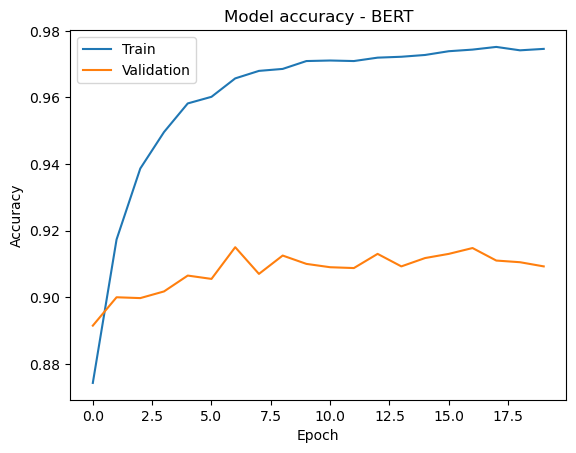

In [84]:
 # Plot the Validation accuracy
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model accuracy - BERT')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()


In [85]:
y_test_pred = pd.read_csv("data/predictions1.csv")

In [86]:
y_pred_labels = y_test_pred['Predicted'].tolist()
len(y_pred_labels)


3990

In [87]:
len(y_test)

3990

In [88]:
y_test_orig = pd.read_csv("data/orig.csv")
y_test_orig = y_test_orig['true']

In [89]:
accuracy_test_bert = accuracy_score(y_test_orig, y_pred_labels)
print("Test Accuracy-BERT: ",accuracy_test_bert)

Test Accuracy-BERT:  0.9255639097744361


In [90]:
# Generate classification report - BERT
print(classification_report(y_test_orig, y_test_pred['Predicted']))

              precision    recall  f1-score   support

           0       0.94      0.83      0.88      1311
           1       0.92      0.97      0.95      2679

    accuracy                           0.93      3990
   macro avg       0.93      0.90      0.91      3990
weighted avg       0.93      0.93      0.92      3990



In [91]:
# Calculate confusion matrix
test_cm = confusion_matrix(y_test_orig, y_pred_labels)
test_cm

array([[1087,  224],
       [  73, 2606]])

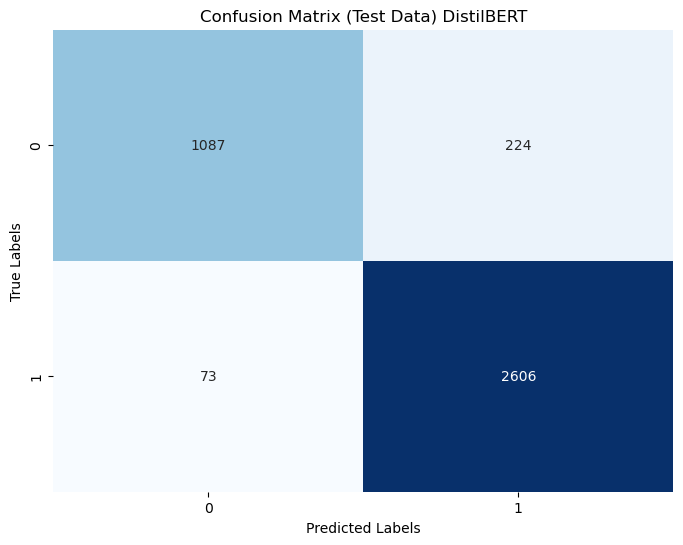

In [92]:
#Visualise the confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(test_cm, annot=True, fmt="d", cmap="Blues", cbar=False,
            xticklabels=np.unique(y_test_orig), yticklabels=np.unique(y_test_orig))
plt.xlabel("Predicted Labels")
plt.ylabel("True Labels")
plt.title("Confusion Matrix (Test Data) DistilBERT")
plt.show()

In [93]:
# Extract input tensors from test_encodings
test_encodings = tokenizer(X_test, truncation=True, padding=True, return_tensors='tf')
test_input_ids = test_encodings['input_ids']
test_attention_mask = test_encodings['attention_mask']

# Make predictions
y_pred_probs = model.predict([test_input_ids, test_attention_mask])['logits']

2023-09-18 12:58:52.904930: W tensorflow/core/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz


125/125 [==============================] - 982s 8s/step


In [94]:
y_pred_probs = tf.nn.sigmoid(y_pred_probs) 
y_pred_probs=y_pred_probs[:, 1]

In [95]:
# Calculate precision-recall curve
precision, recall, _ = precision_recall_curve(y_test_orig, y_pred_probs)
average_precision = np.mean(precision)
average_precision

0.9069673174109706

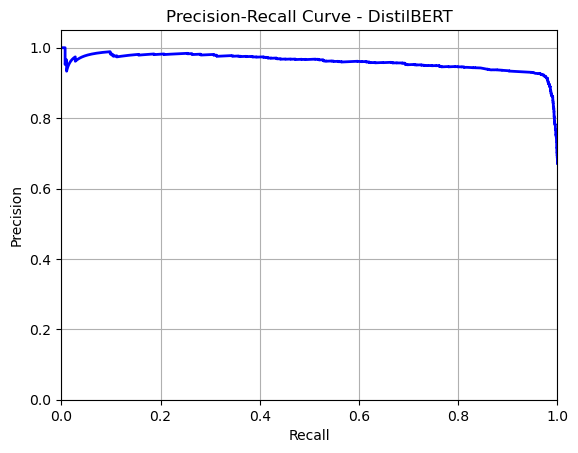

In [96]:
# Plot Precision-Recall Curve
plt.figure()
plt.plot(recall, precision, color='b', lw=2)
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve - DistilBERT')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.grid(True)
plt.show()

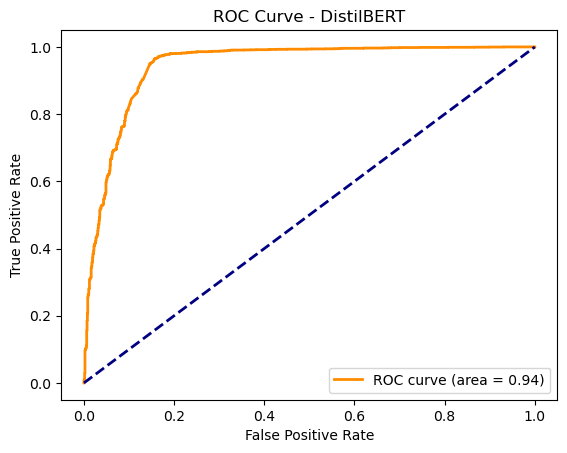

In [97]:
# Calculate ROC curve
fpr, tpr, _ = roc_curve(y_test_orig, y_pred_probs)
roc_auc = auc(fpr, tpr)
# Plot ROC Curve
plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve - DistilBERT')
plt.legend(loc='lower right')
plt.show()

### Prediction of test data - DistilBERT

In [98]:
dfPredicted = pd.DataFrame(columns=['Text', 'Truth', 'Predicted'])
labels = ['Negative','Positive']

test_sentence = "This is a super phone I have used for one month no problem was happened it is a super and Wonder ful phone.......Happy"
predict_input = tokenizer.encode(test_sentence,
                                 truncation=True,
                                 padding=True,
                                 return_tensors="tf")

tf_output = model.predict(predict_input)[0]


tf_prediction = tf.nn.softmax(tf_output, axis=1)
label = tf.argmax(tf_prediction, axis=1)
label = label.numpy()

predData = {'Text': test_sentence, 'Truth': 'Positive', 'Predicted': labels[label[0]]}
new_df = pd.DataFrame([predData])
dfPredicted = dfPredicted.append(predData, ignore_index=True)

1/1 [==============================] - 1s 1s/step


/var/folders/jb/dpgstc9s58q3s_p769xtx63m0000gn/T/ipykernel_29078/552536863.py:19: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  dfPredicted = dfPredicted.append(predData, ignore_index=True)


In [99]:
test_sentence = "I don't understand why manufacturer boast only 2750mah battery.Absolutely rubbish mobile every mobile having quick charge function but it's having quick discharge function."

predict_input = tokenizer.encode(test_sentence,
                                 truncation=True,
                                 padding=True,
                                 return_tensors="tf")

tf_output = model.predict(predict_input)[0]

tf_prediction = tf.nn.softmax(tf_output, axis=1)
label = tf.argmax(tf_prediction, axis=1)
label = label.numpy()
predData = {'Text': test_sentence, 'Truth': 'Negative', 'Predicted': labels[label[0]]}
new_df = pd.DataFrame([predData])
dfPredicted = pd.concat([dfPredicted,new_df], ignore_index=True)

1/1 [==============================] - 1s 587ms/step


In [100]:
test_sentence = "Must Read this full review...  I'm switched from infocus M2 3G to this Lenovo vibe k5 plus... @6749 on BBD sale. After one day use , I write my review From the package I got mobile, battery, charging adapter, data cable, plastic back case, screen protection film but no ear phones. *Design is looking good and handy. *Camera back 13 mp but not better than my infocus M2(8mp) , both are almost equal. *camera front is very clear to take selfies. *touch is very good to use and display amazing. *Dolby speakers , sound is better than normal.*phone is heating very rarely.  *comes to multitasking, 3GB RAM works fine , not hanged till now. *Battery backup is not good as excepted , but OK for normal use. I chooses this mobile for this price tag of Rs.6749 at BBD sale , I would recommend at price tag of 8.5k search for other Mobiles with high battery back up. If u don't want much battery back up, then go for this mobile. Wait wait wait ! The above given review is only after one day use , now I'm editing this review after one month heavy usage of lenevo vibe k5 plus... This is worst phone I've ever used , very much irritating to use , heating , hanging and everything was happening...  Not able to use continuously for 1hour , after continuously using one hour , it heats and hangs on every  action, even calls are not able to attend on that time , only ringtone is ringing but screen is in black... Conclusion : this phone specs only on label 3GB ram , 1.5GHz Octacore,,, this is processing like 512MB ram . I'm saled this bricky mobile to low price , and bought Infocus bingo 50+ and this review also writing on my new Infocus mobile... Guys I'm shared my experience with Lenevo vibe k5 plus , now u decide u wanna buy it not...  Thank you !"

predict_input = tokenizer.encode(test_sentence,
                                 truncation=True,
                                 padding=True,
                                 return_tensors="tf")

tf_output = model.predict(predict_input)[0]


tf_prediction = tf.nn.softmax(tf_output, axis=1)
label = tf.argmax(tf_prediction, axis=1)
label = label.numpy()
predData = {'Text': test_sentence, 'Truth': 'Negative', 'Predicted': labels[label[0]]}
new_df = pd.DataFrame([predData])
dfPredicted = pd.concat([dfPredicted,new_df], ignore_index=True)

1/1 [==============================] - 0s 281ms/step


In [101]:
test_sentence = "very good mobile, built quality and feel in the hand is very good... very fast...3 GB RAM 16 GB internal memory...,,, heats up a bit though but thats not an issue once u upgrade the software,, camera quality is good for proce range...Best buy in this price range... Excellent service from flipkart,,,, package was delivered safely in excellent condition and much before the expected date.. trust only flipcart....great experience"

predict_input = tokenizer.encode(test_sentence,
                                 truncation=True,
                                 padding=True,
                                 return_tensors="tf")

tf_output = model.predict(predict_input)[0]


tf_prediction = tf.nn.softmax(tf_output, axis=1)
label = tf.argmax(tf_prediction, axis=1)
label = label.numpy()
predData = {'Text': test_sentence, 'Truth': 'Positive', 'Predicted': labels[label[0]]}
new_df = pd.DataFrame([predData])
dfPredicted = pd.concat([dfPredicted,new_df], ignore_index=True)

1/1 [==============================] - 0s 83ms/step


In [102]:
test_sentence = "my laptop's battery will last 8 hours when it is fully charged"
predict_input = tokenizer.encode(test_sentence,
                                 truncation=True,
                                 padding=True,
                                 return_tensors="tf")

tf_output = model.predict(predict_input)[0]


tf_prediction = tf.nn.softmax(tf_output, axis=1)
label = tf.argmax(tf_prediction, axis=1)
label = label.numpy()
predData = {'Text': test_sentence, 'Truth': 'Positive', 'Predicted': labels[label[0]]}
print('Prediction: ', labels[label[0]])

1/1 [==============================] - 0s 47ms/step
Prediction:  Negative


In [103]:
dfPredicted

,Text,Truth,Predicted
0,This is a super phone I have used for one mont...,Positive,Positive
1,I don't understand why manufacturer boast only...,Negative,Negative
2,Must Read this full review... I'm switched fr...,Negative,Negative
3,"very good mobile, built quality and feel in th...",Positive,Positive


In [104]:
dfPredicted.to_csv('prediction_BERT.csv', index=True)

## Comparision of accuracy between Naive Bayes, VADER, and DistilBERT

In [105]:
# Models' names
models = ['Naive Bayes', 'VADER', 'DistilBERT']
accuracy_scores = [accuracy_test_nb, accuracy_test_vader, accuracy_test_bert]

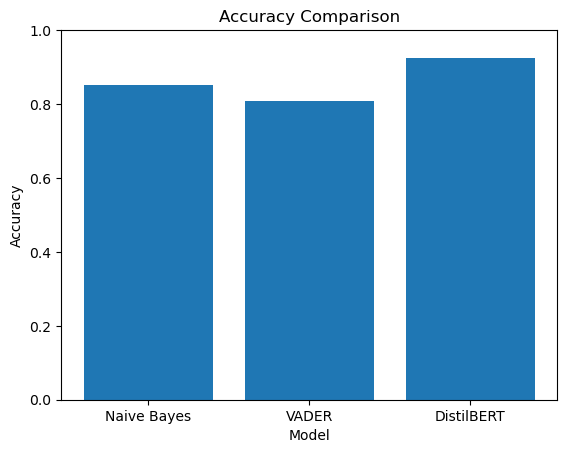

In [106]:
# Plotting
plt.bar(models, accuracy_scores)
plt.xlabel('Model')
plt.ylabel('Accuracy')
plt.title('Accuracy Comparison')
plt.ylim(0, 1)
plt.show()